## Load libraries

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import functools
from pyspark.ml.feature import OneHotEncoder

In [5]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

In [6]:
# Create my_spark or get it if already created
spark = SparkSession.builder.getOrCreate()

## Blog Comments Predictions

In this assignment, we will try to predict the number of comments that a blog post receives based on features of the post. 

Dataset is from the UCI Machine Learning Archive here: https://archive.ics.uci.edu/ml/datasets/BlogFeedback. 
It has 281 columns and we are interested in the last column for prediction, our tartget: number of comments received

## Attribute Information:

1...50: 
Average, standard deviation, min, max and median of the 
Attributes 51...60 for the source of the current blog post 
With source we mean the blog on which the post appeared. 
For example, myblog.blog.org would be the source of 
the post myblog.blog.org/post_2010_09_10 
51: Total number of comments before basetime 
52: Number of comments in the last 24 hours before the 
basetime 
53: Let T1 denote the datetime 48 hours before basetime, 
Let T2 denote the datetime 24 hours before basetime. 
This attribute is the number of comments in the time period 
between T1 and T2 
54: Number of comments in the first 24 hours after the 
publication of the blog post, but before basetime 
55: The difference of Attribute 52 and Attribute 53 
56...60: 
The same features as the attributes 51...55, but 
features 56...60 refer to the number of links (trackbacks), 
while features 51...55 refer to the number of comments. 
61: The length of time between the publication of the blog post 
and basetime 
62: The length of the blog post 
63...262: 
The 200 bag of words features for 200 frequent words of the 
text of the blog post 
263...269: binary indicator features (0 or 1) for the weekday 
(Monday...Sunday) of the basetime 
270...276: binary indicator features (0 or 1) for the weekday 
(Monday...Sunday) of the date of publication of the blog 
post 
277: Number of parent pages: we consider a blog post P as a 
parent of blog post B, if B is a reply (trackback) to 
blog post P. 
278...280: 
Minimum, maximum, average number of comments that the 
parents received 
281: The target: the number of comments in the next 24 hours 
(relative to basetime)

## Read in data
Pyspark handles only numeric data. We can be sure from the results below they are all numbers.

In [7]:
#reading multiple csv in a directory
df_train = spark.read.csv(['C:/Users/IP 320/Desktop/AUEB Assisgments/BlogFeedback/Train'],\
                   inferSchema= True)

df_test = spark.read.csv(['C:/Users/IP 320/Desktop/AUEB Assisgments/BlogFeedback/Test'],\
                   inferSchema= True)

## Target columns and features. 

Here we want to understand the distribution on our target and variables.

This target is the number of comments in the next 24 hours (relative to basetime). Our task to predict this number.

 In the histogram below, we can see that majority of our dataset have received comments in the range of 1 to 50. This means that our data is very skewed and that can means problem when testing our data as we do not have enough information to help us predict other numbers of comments.

Histograms below: 


Text(0.5, 1.0, 'Comments Distribution')

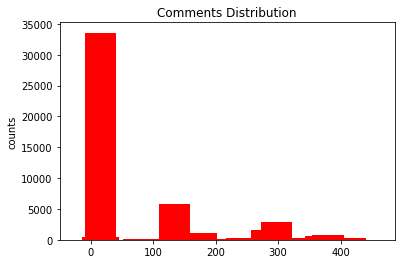

In [8]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

print("Histograms below: ")

comments = df_train.groupBy('_c280').count().collect()
categories = [i[0] for i in comments]
counts = [i[1] for i in comments]

ind = np.array(range(len(categories)))
width = 50
plt.bar(ind, counts, width=width, color='r')

plt.ylabel('counts')
plt.title('Comments Distribution')

In [9]:
from pyspark.sql.functions import col, skewness, kurtosis
for col in df_train.columns[280:281]:
    df_train.select(skewness(col),kurtosis(col)).show()

+------------------+-----------------+
|   skewness(_c280)|  kurtosis(_c280)|
+------------------+-----------------+
|12.691311246278854|232.2954094062568|
+------------------+-----------------+



We can see that most post are posted on Wednesday and Tuesday, with least on Sunday. 
According to our research with the link below, Tuesday and Wednesday are the best days to post on social media.

And lowest engagement is Sunday. Now it all makes sense.

https://sproutsocial.com/insights/best-times-to-post-on-social-media/

In [10]:
import pyspark.sql.functions as F
df_traindays = df_train.withColumnRenamed("_c269", "Mon").\
        withColumnRenamed("_c270", "Tue").\
        withColumnRenamed("_c271", "Wed").\
        withColumnRenamed("_c272", "Thu").\
        withColumnRenamed("_c273", "Fri").\
        withColumnRenamed("_c274", "Sat").\
        withColumnRenamed("_c275", "Sun")

In [11]:
print("Date of publication of the blog post")
popular_dayforcomments_agg = df_traindays.agg(F.sum(df_traindays.Mon),
                                        F.sum(df_traindays.Tue),
                                        F.sum(df_traindays.Wed),
                                        F.sum(df_traindays.Thu),
                                        F.sum(df_traindays.Fri),
                                        F.sum(df_traindays.Sat),
                                        F.sum(df_traindays.Sun)).show()


Date of publication of the blog post
+--------+--------+--------+--------+--------+--------+--------+
|sum(Mon)|sum(Tue)|sum(Wed)|sum(Thu)|sum(Fri)|sum(Sat)|sum(Sun)|
+--------+--------+--------+--------+--------+--------+--------+
|  8343.0|  8786.0|  8977.0|  8501.0|  8093.0|  5038.0|  4659.0|
+--------+--------+--------+--------+--------+--------+--------+



## Correlation to the days of publication

We want to see if there are any really any correlation between the days and number of comments they receive.

I create the list of column names under num_cols and select those preselected columns from the dataframe. Using these columns, I pass it through function statistics corr. In this function, it has a parameters for method. It can include many choices and for this I am using pearson correlation. Other method such as spearman can also be used.

There are some relationship between the days but not a very strong relationship. They are new friendship found. Weak.


In [12]:
#correlations with the days to target variable
from pyspark.mllib.stat import Statistics
import pandas as pd

num_cols = ['_c269', '_c270', '_c271', '_c272', '_c273', '_c274', '_c275', '_c280']
corr_data = df_train.select(num_cols)

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

          _c269     _c270     _c271     _c272     _c273     _c274     _c275     _c280
_c269  1.000000 -0.195329 -0.197874 -0.191510 -0.185995 -0.141937 -0.135951 -0.000284
_c270 -0.195329  1.000000 -0.204088 -0.197524 -0.191836 -0.146395 -0.140221  0.004695
_c271 -0.197874 -0.204088  1.000000 -0.200098 -0.194336 -0.148303 -0.142048 -0.003085
_c272 -0.191510 -0.197524 -0.200098  1.000000 -0.188086 -0.143533 -0.137479 -0.007672
_c273 -0.185995 -0.191836 -0.194336 -0.188086  1.000000 -0.139399 -0.133520  0.008056
_c274 -0.141937 -0.146395 -0.148303 -0.143533 -0.139399  1.000000 -0.101892  0.000869
_c275 -0.135951 -0.140221 -0.142048 -0.137479 -0.133520 -0.101892  1.000000 -0.002905
_c280 -0.000284  0.004695 -0.003085 -0.007672  0.008056  0.000869 -0.002905  1.000000


## Build Linear Regression Model

## Prepare labeled set - 'features' and 'labels'

I understand that the data may be skewed and we need to log the data.

We will can see the r2 value and random forest gave use the better r2 score at 0.37. 

In [13]:
# Create assembler for train
label_col_train = df_train.columns[-1]

assembler = VectorAssembler(
    inputCols=[ x for x in df_train.columns[:-1] ],
    outputCol='features')

In [14]:
train_a = assembler.transform(df_train)

In [15]:
# Create assembler for test
label_col_test = df_test.columns[-1]

assembler = VectorAssembler(
    inputCols=[ x for x in df_test.columns[:-1] ],
    outputCol='features')

In [16]:
test_a = assembler.transform(df_test)

In [17]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, labelCol= label_col_train, elasticNetParam=0.8)

In [18]:
# Fit the model
lrModel = lr.fit(train_a)

In [19]:
# Print the intercept for linear regression
print("Intercept: %s" % str(lrModel.intercept))

Intercept: 5.934188421829072


In [20]:
training_predictions=lrModel.evaluate(train_a)

In [21]:
training_predictions.meanSquaredError

918.3465108604942

In [22]:
training_predictions.r2

0.35407672011159796

In [23]:
#make predictions on test data 
test_results=lrModel.evaluate(test_a)

In [24]:
#view the residual errors based on predictions 
test_results.residuals.show(10)

+------------------+
|         residuals|
+------------------+
|-0.395124054014091|
|-7.671163253091358|
| 4.689294185571059|
| 1.749078331569856|
|-1.793563867274801|
| 7.789119527331314|
|-4.881671878630961|
| 5.348886157627678|
|-35.13276479001333|
| -8.89745726685041|
+------------------+
only showing top 10 rows



In [25]:
#coefficient of determination value for model
test_results.r2

0.3375313998543865

In [26]:
test_results.rootMeanSquaredError

24.82452330119175

In [27]:
test_results.meanSquaredError

616.2569571314122

## Build Decision Tree

In [28]:
def transData(data): return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [29]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

transformed= transData(df_train)
transformed.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[40.30467,53.8456...|  1.0|
|[40.30467,53.8456...|  0.0|
|[40.30467,53.8456...|  0.0|
|[40.30467,53.8456...|  1.0|
|[40.30467,53.8456...| 27.0|
+--------------------+-----+
only showing top 5 rows



In [30]:
# convert the data to dense vector
def transData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).\
           toDF(['label','features'])

transformed = transData(df_train)
transformed.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[40.30467,53.8456...|
|  0.0|[40.30467,53.8456...|
|  0.0|[40.30467,53.8456...|
|  1.0|[40.30467,53.8456...|
| 27.0|[40.30467,53.8456...|
+-----+--------------------+
only showing top 5 rows



In [31]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4
# distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)

In [32]:
data.show(2)

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  1.0|[40.30467,53.8456...|[40.30467,53.8456...|
|  0.0|[40.30467,53.8456...|[40.30467,53.8456...|
+-----+--------------------+--------------------+
only showing top 2 rows



In [33]:
testtransformed= transData(df_test)
testtransformed.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[6.004717,37.5324...|
|  2.0|[7.7777777,6.1604...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[34.589355,98.559...|
|  0.0|[0.0,0.0,0.0,0.0,...|
+-----+--------------------+
only showing top 5 rows



In [34]:
featureIndexertest = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(testtransformed)

test_data = featureIndexertest.transform(testtransformed)

In [35]:
test_data.show(2)

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  0.0|[6.004717,37.5324...|[6.004717,37.5324...|
|  2.0|[7.7777777,6.1604...|[7.7777777,6.1604...|
+-----+--------------------+--------------------+
only showing top 2 rows



In [36]:
from pyspark.ml.regression import DecisionTreeRegressor

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

In [37]:
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

model = pipeline.fit(data)

In [38]:
# Make predictions.
predictions = model.transform(test_data)

In [39]:
# Select example rows to display.
predictions.select("features","label","prediction").show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[6.004717,37.5324...|  0.0|0.5627904291857881|
|[7.7777777,6.1604...|  2.0|0.5627904291857881|
|[0.0,0.0,0.0,0.0,...|  0.0|0.5627904291857881|
|[34.589355,98.559...|  0.0|0.5627904291857881|
|[0.0,0.0,0.0,0.0,...|  0.0|0.5627904291857881|
+--------------------+-----+------------------+
only showing top 5 rows



In [40]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 24.1084


In [41]:
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.37520240923381665


## Random Forest

In [43]:
# Import LinearRegression class
from pyspark.ml.regression import RandomForestRegressor

# Define LinearRegression algorithm
rf = RandomForestRegressor(featuresCol="indexedFeatures",numTrees=2, maxDepth=2, seed=42)

In [44]:
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])
model = pipeline.fit(data)

In [45]:
predictions = model.transform(test_data)

# Select example rows to display.
predictions.select("features","label", "prediction").show(5)

+--------------------+-----+----------------+
|            features|label|      prediction|
+--------------------+-----+----------------+
|[6.004717,37.5324...|  0.0|2.63584185079476|
|[7.7777777,6.1604...|  2.0|2.63584185079476|
|[0.0,0.0,0.0,0.0,...|  0.0|2.63584185079476|
|[34.589355,98.559...|  0.0|2.63584185079476|
|[0.0,0.0,0.0,0.0,...|  0.0|2.63584185079476|
+--------------------+-----+----------------+
only showing top 5 rows



In [46]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 25.2131


In [47]:
import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {:4.3f}'.format(r2_score))

r2_score: 0.375


In [48]:
model.stages[-1].featureImportances

SparseVector(280, {20: 0.0206, 28: 0.5967, 52: 0.1752, 54: 0.2075})

In [52]:
model.stages[-1].trees

[DecisionTreeRegressionModel (uid=dtr_e39fe222df34) of depth 2 with 7 nodes,
 DecisionTreeRegressionModel (uid=dtr_6d8ca6d249cd) of depth 2 with 7 nodes]